# Import required libraries

In [35]:
# Import necessary libraries for data manipulation, visualization, and clustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load the dataset

In [36]:
# Load the dataset from a CSV file
retail = pd.read_csv('OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)


## Display the first few rows of the dataset

In [37]:
# Display the first few rows of the dataset to understand its structure
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,1/12/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,1/12/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,1/12/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,1/12/2010 8:26,3.39,17850.0,United Kingdom


## Check the shape of the dataset

In [38]:
# Check the number of rows and columns in the dataset
retail.shape

(541909, 8)

## Dataset information

In [39]:
# Get information about the dataset, including column names and data types
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## Calculate missing values

In [40]:
# Calculate the percentage of missing values for each column
df_null = round(100*retail.isnull().sum()/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

## Drop rows with missing values

In [41]:
# Drop rows that have missing values and check the new shape of the dataset
retail = retail.dropna()
retail.shape

(406829, 8)

## Convert CustomerID to string

In [42]:
# Change the data type of the 'CustomerID' column to string
retail['CustomerID'] = retail['CustomerID'].astype(str)


## Create a new attribute: Monetary

In [43]:
# Create a new attribute 'Amount' by multiplying 'Quantity' and 'UnitPrice'
retail['Amount'] = retail['Quantity'] * retail['UnitPrice']
# Group by 'CustomerID' and calculate the total monetary value for each customer
rfm_m = retail.groupby('CustomerID')['Amount'].sum().reset_index()
rfm_m.head()


,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


## Create a new attribute: Frequency

In [44]:
# Group by 'CustomerID' and calculate the frequency of purchases for each customer
rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count().reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()


,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


## Merge Monetary and Frequency dataframes

In [45]:
# Merge the two dataframes on 'CustomerID'
rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()


,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


## Create a new attribute: Recency

In [47]:
# New Attribute : Recency

# Convert to datetime to proper datatype

from datetime import datetime

def standardize_date_format(date_str):
    # Possible date formats in the input
    date_formats = ["%d-%m-%Y %H:%M", "%d/%m/%Y %H:%M", "%d/%m/%Y %H:%M:%S", "%m/%d/%Y %H:%M", "%m/%d/%Y %H:%M:%S"]
    
    for date_format in date_formats:
        try:
            date_obj = datetime.strptime(date_str, date_format)
            return date_obj.strftime("%d-%m-%Y %H:%M")
        except ValueError:
            continue
    
    # If no formats matched, raise an error
    raise ValueError(f"Date format for '{date_str}' is not recognized.")
    
retail['InvoiceDate'] = retail['InvoiceDate'].apply(standardize_date_format)

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')
retail['InvoiceDate']

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541904   2011-12-09 12:50:00
541905   2011-12-09 12:50:00
541906   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 406829, dtype: datetime64[ns]

In [49]:
# Compute the maximum date to know the last transaction date

max_date = retail['InvoiceDate'].max()
max_date

Timestamp('2011-12-09 12:50:00')

In [50]:
# Compute the difference between max date and transaction date

# retail['Diff'] = max_date - retail['InvoiceDate']
retail['Diff'] = (max_date - retail['InvoiceDate']).dt.days
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373


In [51]:
# Compute recency of customer

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [52]:
# Merge the dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12348.0,1797.24,31,74
2,12349.0,1757.55,73,18
3,12350.0,334.40,17,309
4,12352.0,1545.41,95,35


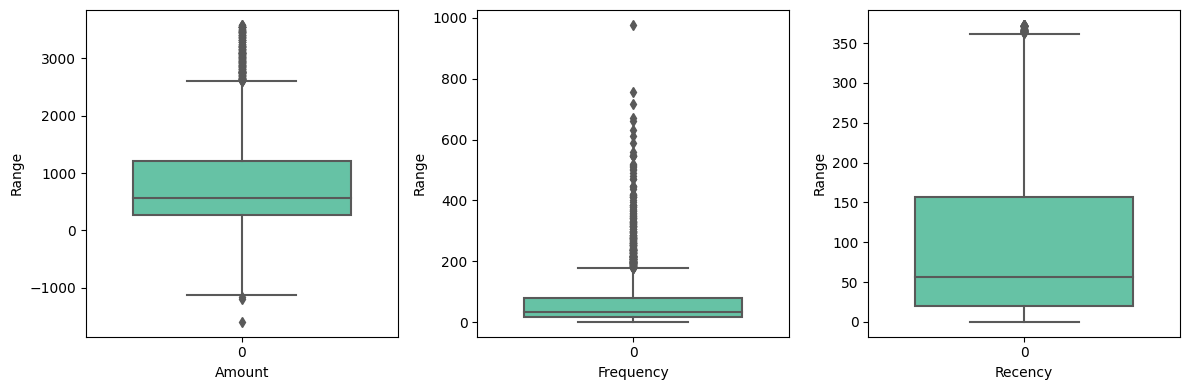

<Figure size 640x480 with 0 Axes>

In [53]:
# Outlier Analysis of Amount Frequency and Recency

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.boxplot(data = rfm['Amount'], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.xlabel('Amount')
plt.ylabel('Range')

plt.subplot(1, 3, 2)
sns.boxplot(data = rfm['Frequency'], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.xlabel('Frequency')
plt.ylabel('Range')

plt.subplot(1, 3, 3)
sns.boxplot(data = rfm['Recency'], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.xlabel('Recency')
plt.ylabel('Range')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

## Handling outliers

In [54]:
# Remove statistical outliers from the 'Amount', 'Frequency', and 'Recency' columns
Q1 = rfm.Amount.quantile(0.25)
Q3 = rfm.Amount.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5 * IQR) & (rfm.Amount <= Q3 + 1.5 * IQR)]

Q1 = rfm.Recency.quantile(0.25)
Q3 = rfm.Recency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5 * IQR) & (rfm.Recency <= Q3 + 1.5 * IQR)]

Q1 = rfm.Frequency.quantile(0.25)
Q3 = rfm.Frequency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5 * IQR) & (rfm.Frequency <= Q3 + 1.5 * IQR)]


## Standardize the data

In [55]:
# Select the relevant columns and standardize the data
rfm_df = rfm[['Amount', 'Frequency', 'Recency']]
scaler = StandardScaler()
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled = pd.DataFrame(rfm_df_scaled, columns=['Amount', 'Frequency', 'Recency'])
rfm_df_scaled.head()


,Amount,Frequency,Recency
0,-1.144846,-1.106637,2.087971
1,1.921035,-0.300796,-0.310012
2,1.853328,0.866283,-0.845020
3,-0.574399,-0.689823,1.935111
4,1.491442,1.477610,-0.682607


## K-means clustering

In [56]:
# Apply K-means clustering with an arbitrary number of clusters
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)


KMeans(max_iter=50, n_clusters=4)

In [57]:
kmeans.labels_

array([0, 1, 3, ..., 0, 2, 3])

In [58]:
set(kmeans.labels_)

{0, 1, 2, 3}

## Determine the optimal number of clusters

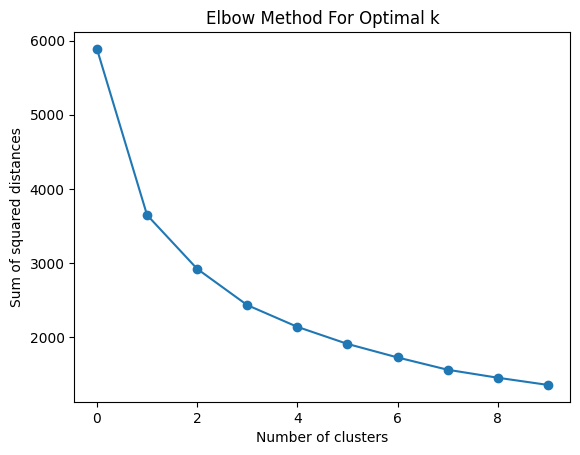

In [60]:
# Determine the optimal number of clusters using the Elbow method
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    ssd.append(kmeans.inertia_)

# Plot the sum of squared distances for each number of clusters
plt.plot(ssd, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()


## Final K-means model

In [61]:
# Apply K-means clustering with the optimal number of clusters (k=3)
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

# Assign the cluster labels to the original dataframe
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()


,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,1
1,12348.0,1797.24,31,74,0
2,12349.0,1757.55,73,18,0
3,12350.0,334.40,17,309,1
4,12352.0,1545.41,95,35,0


## Visualize the clusters

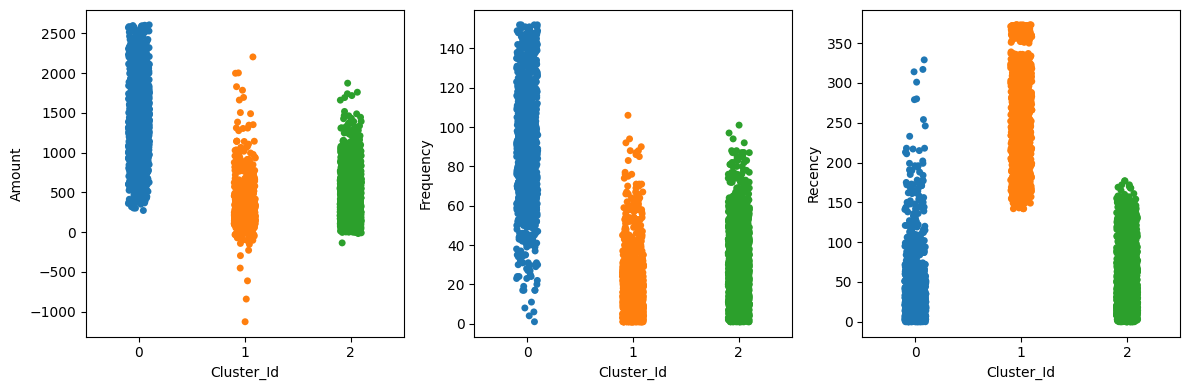

In [62]:
# Visualize the clusters using strip plots for Amount, Frequency, and Recency
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.stripplot(x='Cluster_Id', y='Amount', data=rfm)
plt.xlabel('Cluster_Id')
plt.ylabel('Amount')

plt.subplot(1, 3, 2)
sns.stripplot(x='Cluster_Id', y='Frequency', data=rfm)
plt.xlabel('Cluster_Id')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.stripplot(x='Cluster_Id', y='Recency', data=rfm)
plt.xlabel('Cluster_Id')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()


## Key Insights
#### 1. Customer Segmentation:
The customers have been segmented into three clusters based on their purchasing behavior. Each cluster represents customers with similar patterns in monetary value, frequency, and recency.

#### 2. High-value Customers:
One of the clusters represents high-value customers who make frequent and high-value purchases. Targeting these customers with special offers and loyalty programs can be beneficial.

#### 3. Inactive Customers:
Another cluster includes inactive customers with high recency values, indicating they haven't made purchases recently. Re-engagement strategies can be developed for this group.

#### 4. Moderate Customers:
The third cluster consists of moderate customers with average spending and frequency. Marketing strategies can be tailored to encourage more frequent purchases from this segment.

#### 5. Data Preprocessing:
Handling missing values, converting data types, and removing outliers are crucial steps in preparing the data for clustering.

#### 6. Feature Engineering:
Creating new attributes like Monetary, Frequency, and Recency helps in better understanding customer behavior and improving the clustering process.

#### 7. Standardization:
Standardizing the data ensures that all features contribute equally to the clustering algorithm, improving the accuracy of the clusters.

#### 8. Elbow Method:
The elbow method helps in determining the optimal number of clusters, ensuring that the chosen number of clusters provides the best fit for the data without overfitting.

Based on the updated understanding of the clusters' spending, recency, and frequency patterns, let's revise the analysis and insights accordingly.

### Strip Plot Analysis

#### 1. **Cluster 0**
- **Amount**: Customers in Cluster 0 have the highest spending amounts.
- **Frequency**: The frequency of purchases for this cluster is relatively low. Most customers have fewer purchase transactions.
- **Recency**: This cluster has the lowest recency values, indicating that they have made very recent purchases.

#### 2. **Cluster 1**
- **Amount**: Cluster 1 contains customers with the lowest spending amounts.
- **Frequency**: Customers in this cluster make purchases less frequently compared to Cluster 2 but more frequently than Cluster 0.
- **Recency**: This cluster has the highest recency values, indicating that they have not made purchases recently.

#### 3. **Cluster 2**
- **Amount**: Customers in Cluster 2 generally have moderate spending amounts.
- **Frequency**: The frequency of purchases in this cluster is the highest. Customers here make frequent transactions.
- **Recency**: This cluster has moderate recency values, indicating that customers in this cluster have made recent purchases, but not as recent as those in Cluster 0.

### Insights from Customer Segmentation

1. **High-value and Recently Active Customers (Cluster 0)**:
   - These customers spend the most money and have made recent transactions, though their purchase frequency is low.
   - They are valuable due to their high spending and recent activity. They should be prioritized for retention strategies to maintain their engagement and encourage more frequent purchases.

2. **Low-value and Inactive Customers (Cluster 1)**:
   - This segment consists of customers with the lowest spending and infrequent purchases, and they have not made purchases recently.
   - Re-engagement strategies such as reactivation campaigns, discounts, and personalized offers can be developed to bring these customers back to active status and increase their spending and purchase frequency.

3. **Moderate-value and Active Customers (Cluster 2)**:
   - These customers have moderate spending amounts and make frequent purchases. Their recency values indicate they have made recent transactions, though not as recent as Cluster 0.
   - Marketing efforts can be directed towards maintaining their activity and increasing their spending through targeted promotions and incentives.

### Strategic Recommendations

- **Cluster 0**: Implement strategies to increase purchase frequency, such as loyalty programs, early access to sales, and personalized recommendations to keep these high-value customers engaged.
- **Cluster 1**: Focus on re-engagement strategies to bring these low-value and inactive customers back. This can include email campaigns highlighting new products, special discounts for returning customers, and personalized marketing based on their previous purchase behavior.
- **Cluster 2**: Encourage more spending through targeted promotions, cross-selling, and up-selling techniques. Offering incentives for higher spending can help increase their overall value.

By tailoring marketing strategies to each customer segment, businesses can maximize customer lifetime value, improve customer retention, and increase overall profitability.